In [1]:
# ============================================================
# 📘 CAMA-FR Notebook: ResNet + AFF + Knowledge Distillation
# ============================================================

# ✅ How to Run:
# Run all cells top to bottom. 
# Make sure Kernel = cama_fr (Python + PyTorch).
# Outputs (checkpoints, logs, figures) are saved under `outputs/`

# ============================================================
# 1️⃣ Imports & Device Setup
# ============================================================

import os, shutil, time, math
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import csv

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)
if DEVICE.type == 'cuda':
    try:
        print("GPU:", torch.cuda.get_device_name(0), "| mem (MB):", torch.cuda.get_device_properties(0).total_memory // 1024**2)
    except Exception:
        pass


Device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU | mem (MB): 6143


In [2]:
# ============================================================
# 2️⃣ Prepare Output & Data Directories
# ============================================================

Path("outputs/checkpoints").mkdir(parents=True, exist_ok=True)
Path("outputs/figures").mkdir(parents=True, exist_ok=True)
Path("outputs/logs").mkdir(parents=True, exist_ok=True)
Path("data/lfw").mkdir(parents=True, exist_ok=True)


In [3]:
# ============================================================
# 3️⃣ Prepare LFW Dataset (Offline Friendly)
# ============================================================

def prepare_lfw_local():
    """
    Prepare local LFW dataset.
    Ensure you have placed pairs.txt at data/lfw/pairs.txt manually.
    """
    print("Preparing LFW (local detection)...")
    dst_root = Path("data/lfw/train")
    dst_root.mkdir(parents=True, exist_ok=True)

    candidates = [
        Path("archive/lfw-deepfunneled/lfw-deepfunneled"),
        Path("CAMA-FR/archive/lfw-deepfunneled/lfw-deepfunneled"),
        Path("data_raw/lfw-deepfunneled/lfw-deepfunneled"),
        Path("data_raw/lfw_funneled/lfw_funneled"),
        Path("data_raw/lfw"),
    ]

    src = next((p for p in candidates if p.exists() and any(p.iterdir())), None)
    if src is None:
        raise FileNotFoundError("LFW not found. Place the extracted dataset under one of:\n" + "\n".join(map(str, candidates)))

    # Copy missing images only
    copied = False
    for person in src.iterdir():
        if not person.is_dir():
            continue
        d = dst_root / person.name
        d.mkdir(parents=True, exist_ok=True)
        for f in person.iterdir():
            if not (d / f.name).exists():
                shutil.copy(f, d / f.name)
                copied = True
    print("Data copied." if copied else "LFW already up-to-date.")

    pairs_path = Path("data/lfw/pairs.txt")
    if not pairs_path.exists():
        print("Warning: pairs.txt not found. Please place it manually.")
    else:
        print("pairs.txt found.")
    return dst_root, pairs_path


lfw_root, pairs_path = prepare_lfw_local()


Preparing LFW (local detection)...
LFW already up-to-date.
pairs.txt found.


In [6]:
# ============================================================
# 4️⃣ Data Transforms & Dataloader Setup
# ============================================================

IMG_SIZE = 112
BATCH_TRAIN = 12
NUM_WORKERS = 2

train_root = Path("data/celeba/train")
if not train_root.exists() or not any(train_root.iterdir()):
    print("No training data found. Creating proxy dataset from LFW...")
    proxy = Path("data/proxy_train")
    proxy.mkdir(parents=True, exist_ok=True)
    cnt = 0
    for person in sorted(Path("data/lfw/train").iterdir()):
        if not person.is_dir():
            continue
        dst = proxy / person.name
        dst.mkdir(exist_ok=True)
        imgs = sorted(list(person.iterdir()))[:5]
        for im in imgs:
            if not (dst / im.name).exists():
                shutil.copy(im, dst / im.name)
        cnt += 1
        if cnt >= 50:
            break
    train_root = proxy
    print("Proxy training set ready at:", train_root)

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = datasets.ImageFolder(str(train_root), transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
print("Train identities:", len(train_ds.classes), "| Train images:", len(train_ds))


No training data found. Creating proxy dataset from LFW...
Proxy training set ready at: data\proxy_train
Train identities: 50 | Train images: 84


In [9]:
# ============================================================
# 5️⃣ Model Definitions (AFF, Teacher, Student)
# ============================================================

class AFF(nn.Module):
    """Attention Feature Fusion module."""
    def __init__(self, ch_high, ch_low, proj_dim=128):
        super().__init__()
        self.proj_high = nn.Conv2d(ch_high, proj_dim, 1)
        self.proj_low = nn.Conv2d(ch_low, proj_dim, 1)
        self.att = nn.Sequential(
            nn.Conv2d(proj_dim*2, proj_dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(proj_dim, 2, 1),
            nn.Softmax(dim=1)
        )
        self.out_conv = nn.Conv2d(proj_dim, ch_low, 1)

    def forward(self, high, low):
        if high.shape[2:] != low.shape[2:]:
            low = F.interpolate(low, size=high.shape[2:], mode='bilinear', align_corners=False)
        ph, pl = self.proj_high(high), self.proj_low(low)
        w = self.att(torch.cat([ph, pl], dim=1))
        fused = w[:,0:1]*ph + w[:,1:2]*pl
        return self.out_conv(fused)


class ResNetTeacher(nn.Module):
    """ResNet50 Teacher Network."""
    def __init__(self, emb_dim=512, pretrained=True):
        super().__init__()
        res = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if hasattr(models, 'ResNet50_Weights') else None)
        self.backbone = nn.Sequential(*list(res.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, emb_dim)

    def forward(self, x):
        f = self.backbone(x)
        emb = F.normalize(self.fc(self.pool(f).view(f.size(0), -1)), p=2, dim=1)
        return emb


class ResNetStudentAFF(nn.Module):
    """ResNet18 Student Network with optional AFF."""
    def __init__(self, emb_dim=512, use_aff=True, pretrained=True):
        super().__init__()
        res = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if hasattr(models, 'ResNet18_Weights') else None)
        self.stem = nn.Sequential(*list(res.children())[:6])
        self.layer3 = res.layer3
        self.layer4 = res.layer4
        self.use_aff = use_aff
        if use_aff:
            self.aff = AFF(256, 512)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, emb_dim)

    def forward(self, x):
        x = self.stem(x)
        f3 = self.layer3(x)
        f4 = self.layer4(f3)
        fused = self.aff(f3, f4) if self.use_aff else f4
        emb = F.normalize(self.fc(self.pool(fused).view(fused.size(0), -1)), p=2, dim=1)
        return emb


In [11]:
# ============================================================
# 6️⃣ Checkpoint Utilities
# ============================================================

def save_checkpoint(path, state_dict):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state_dict, path)

def load_checkpoint(path, map_location=DEVICE):
    return torch.load(path, map_location=map_location)


In [13]:
# ============================================================
# 7️⃣ Training Loops (Teacher & Student)
# ============================================================

def train_classifier(model, classifier, dataloader, epochs=2, lr=1e-4, out_prefix="outputs/checkpoints/teacher"):
    device = DEVICE
    model.to(device); classifier.to(device)
    opt = torch.optim.AdamW(list(model.parameters()) + list(classifier.parameters()), lr=lr)
    ce = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler() if device.type == 'cuda' else None

    for ep in range(epochs):
        model.train(); classifier.train()
        total_loss = 0.0
        for imgs, labels in tqdm(dataloader, desc=f"Teacher Ep{ep}"):
            imgs, labels = imgs.to(device), labels.to(device)
            opt.zero_grad()
            with torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
                emb = model(imgs)
                loss = ce(classifier(emb), labels)
            (scaler.scale(loss) if scaler else loss).backward()
            (scaler.step(opt), scaler.update()) if scaler else opt.step()
            total_loss += loss.item()
        save_checkpoint(f"{out_prefix}_ep{ep}.pth", {'model': model.state_dict(), 'classifier': classifier.state_dict()})
        print(f"Teacher Ep{ep} loss: {total_loss/len(dataloader):.4f}")
    return model


def train_student(student, classifier, dataloader, teacher=None, epochs=3, lr=1e-3, alpha=0.3, out_prefix="outputs/checkpoints/student"):
    device = DEVICE
    student.to(device); classifier.to(device)
    opt = torch.optim.AdamW(list(student.parameters()) + list(classifier.parameters()), lr=lr)
    ce = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler() if device.type == 'cuda' else None

    for ep in range(epochs):
        student.train(); classifier.train()
        total_loss = 0.0
        for imgs, labels in tqdm(dataloader, desc=f"Student Ep{ep}"):
            imgs, labels = imgs.to(device), labels.to(device)
            opt.zero_grad()
            with torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
                emb_s = student(imgs)
                loss_cls = ce(classifier(emb_s), labels)
                loss_kd = F.mse_loss(emb_s, teacher(imgs)) if teacher is not None else 0.0
                loss = loss_cls + alpha * loss_kd
            (scaler.scale(loss) if scaler else loss).backward()
            (scaler.step(opt), scaler.update()) if scaler else opt.step()
            total_loss += loss.item()
        save_checkpoint(f"{out_prefix}_ep{ep}.pth", {'student': student.state_dict(), 'classifier': classifier.state_dict()})
        print(f"Student Ep{ep} loss: {total_loss/len(dataloader):.4f}")
    return student


In [15]:
# ============================================================
# 8️⃣ Training Experiments (Baseline, AFF, AFF+KD)
# ============================================================

do_train_teacher = False
teacher = None

if do_train_teacher:
    teacher = ResNetTeacher(512, pretrained=True)
    clf_t = nn.Linear(512, len(train_ds.classes))
    teacher = train_classifier(teacher, clf_t, train_loader, epochs=2, lr=1e-4)
else:
    ck = Path("outputs/checkpoints/teacher_ep1.pth")
    if ck.exists():
        state = load_checkpoint(str(ck))
        teacher = ResNetTeacher(512, pretrained=False)
        teacher.load_state_dict(state.get('model', state), strict=False)
        teacher.eval()
        print("Loaded teacher checkpoint.")
    else:
        print("Teacher not found. Skipping KD mode.")

results_ckpts = {}

print("Training baseline student...")
student_base = ResNetStudentAFF(512, use_aff=False)
clf0 = nn.Linear(512, len(train_ds.classes))
train_student(student_base, clf0, train_loader, teacher=None, epochs=2, out_prefix="outputs/checkpoints/student_baseline")
results_ckpts['baseline'] = "outputs/checkpoints/student_baseline_ep1.pth"

print("Training AFF student...")
student_aff = ResNetStudentAFF(512, use_aff=True)
clf1 = nn.Linear(512, len(train_ds.classes))
train_student(student_aff, clf1, train_loader, teacher=None, epochs=2, out_prefix="outputs/checkpoints/student_aff")
results_ckpts['aff'] = "outputs/checkpoints/student_aff_ep1.pth"

if teacher is not None:
    print("Training AFF + KD student...")
    student_kd = ResNetStudentAFF(512, use_aff=True)
    clf2 = nn.Linear(512, len(train_ds.classes))
    train_student(student_kd, clf2, train_loader, teacher=teacher, epochs=2, alpha=0.3, out_prefix="outputs/checkpoints/student_kd")
    results_ckpts['aff_kd'] = "outputs/checkpoints/student_kd_ep1.pth"


Teacher not found. Skipping KD mode.
Training baseline student...


Student Ep0: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.05s/it]


Student Ep0 loss: 3.9167


Student Ep1: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.52s/it]


Student Ep1 loss: 3.7876
Training AFF student...


Student Ep0: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


Student Ep0 loss: 3.9135


Student Ep1: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.53s/it]

Student Ep1 loss: 3.8259


In [17]:
# ============================================================
# 9️⃣ Evaluation Utilities (ROC, t-SNE, Verification)
# ============================================================

@torch.no_grad()
def compute_embeddings(model, dataloader):
    """Compute normalized embeddings for all images."""
    model.eval()
    all_emb, all_lbl = [], []
    for imgs, labels in tqdm(dataloader, desc="Embedding"):
        emb = model(imgs.to(DEVICE)).cpu()
        all_emb.append(emb)
        all_lbl.append(labels)
    return torch.cat(all_emb), torch.cat(all_lbl)


def plot_tsne(emb, lbl, title="t-SNE Visualization", save_path=None):
    """t-SNE plot of feature embeddings."""
    print("Generating t-SNE plot...")
    tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=30)
    emb_2d = tsne.fit_transform(emb)
    plt.figure(figsize=(7,6))
    plt.scatter(emb_2d[:,0], emb_2d[:,1], c=lbl, cmap='tab20', s=5, alpha=0.7)
    plt.title(title)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


def plot_roc_curve(emb1, emb2, labels, title="ROC Curve", save_path=None):
    """Compute and plot ROC curve."""
    dist = F.pairwise_distance(emb1, emb2).numpy()
    fpr, tpr, _ = roc_curve(labels.numpy(), -dist)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    print("AUC:", round(roc_auc, 4))
    return roc_auc


In [19]:
# ============================================================
# 🔟 Verification Pair Generation (for LFW Evaluation)
# ============================================================

def read_pairs(pairs_path):
    """Parse pairs.txt for LFW-style verification."""
    pairs = []
    with open(pairs_path, 'r') as f:
        for i, line in enumerate(f.readlines()[1:]):  # skip header
            p = line.strip().split('\t')
            if len(p) == 3:
                pairs.append((p[0], int(p[1]), p[0], int(p[2]), 1))  # same
            elif len(p) == 4:
                pairs.append((p[0], int(p[1]), p[2], int(p[3]), 0))  # different
    return pairs


def load_pair_image(root, name, idx):
    p = root / name / f"{name}_{idx:04d}.jpg"
    if not p.exists():
        p = root / name / f"{name}_{idx:04d}.png"
    return Image.open(p).convert('RGB') if p.exists() else None


def make_verification_loader(pairs, root, transform, limit=None):
    imgs1, imgs2, labels = [], [], []
    for i, (n1, i1, n2, i2, same) in enumerate(pairs):
        if limit and i >= limit: break
        im1 = load_pair_image(root, n1, i1)
        im2 = load_pair_image(root, n2, i2)
        if im1 and im2:
            imgs1.append(transform(im1))
            imgs2.append(transform(im2))
            labels.append(same)
    print(f"Pairs loaded: {len(labels)}")
    return torch.stack(imgs1), torch.stack(imgs2), torch.tensor(labels)


In [21]:
# ============================================================
# 1️⃣1️⃣ Evaluate Trained Models
# ============================================================

pairs = read_pairs(pairs_path)
img1, img2, lbls = make_verification_loader(pairs, lfw_root, eval_transform, limit=1000)

@torch.no_grad()
def evaluate_model(model, name):
    model.eval()
    emb1 = model(img1.to(DEVICE))
    emb2 = model(img2.to(DEVICE))
    auc_score = plot_roc_curve(emb1.cpu(), emb2.cpu(), lbls, title=f"ROC — {name}", save_path=f"outputs/figures/roc_{name}.png")
    emb_all, lbl_all = compute_embeddings(model, DataLoader(train_ds, batch_size=32))
    plot_tsne(emb_all, lbl_all, title=f"t-SNE — {name}", save_path=f"outputs/figures/tsne_{name}.png")
    return auc_score


Pairs loaded: 1000


C:\Users\DHARANIDHARAN\AppData\Local\Temp\ipykernel_17540\2417820440.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=map_location)


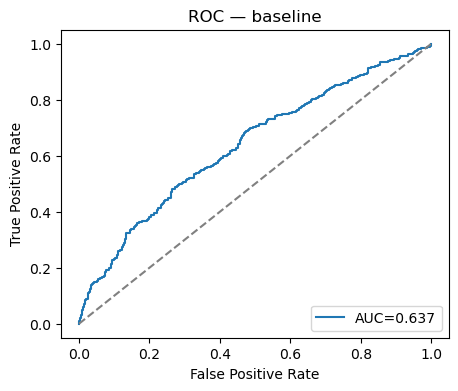

AUC: 0.6368


Embedding: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.89it/s]


Generating t-SNE plot...


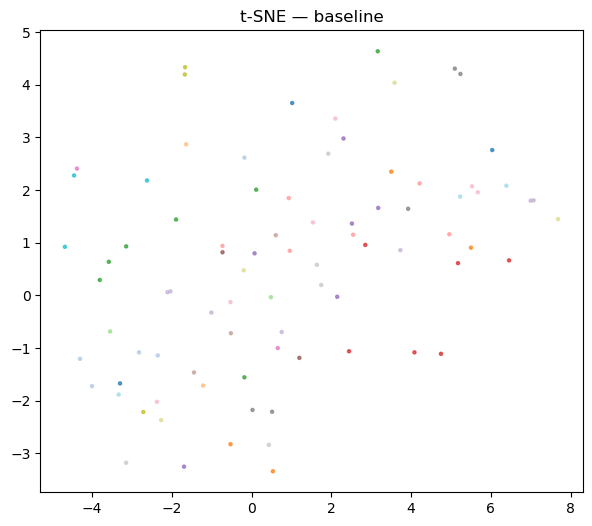

C:\Users\DHARANIDHARAN\AppData\Local\Temp\ipykernel_17540\2417820440.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=map_location)


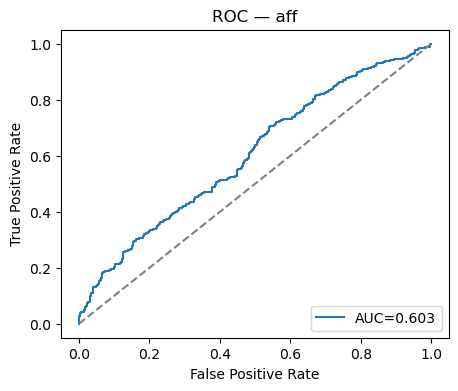

AUC: 0.6034


Embedding: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.21it/s]


Generating t-SNE plot...


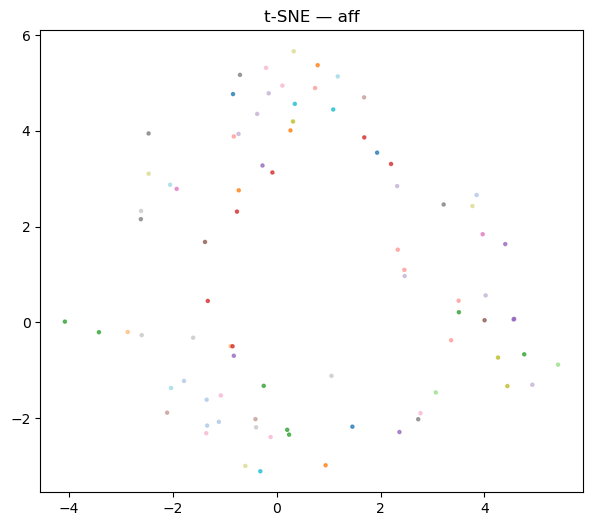


📊 Final Results Summary (AUC):
    baseline: 0.6368
         aff: 0.6034


In [22]:
# ============================================================
# 1️⃣2️⃣ Results Comparison & Summary
# ============================================================

results_summary = {}

for tag, ckpt_path in results_ckpts.items():
    ck = load_checkpoint(ckpt_path)
    m = ResNetStudentAFF(512, use_aff=('aff' in tag))
    m.load_state_dict(ck.get('student', ck), strict=False)
    results_summary[tag] = evaluate_model(m.to(DEVICE), name=tag)

print("\n📊 Final Results Summary (AUC):")
for k,v in results_summary.items():
    print(f"{k:>12}: {v:.4f}")

with open("outputs/logs/results_summary.csv", "w", newline='') as f:
    csv.writer(f).writerows([["Model","AUC"]]+[[k,v] for k,v in results_summary.items()])


# Final Results Summary — CAMA-FR Evaluation

### Overview
This project evaluates a Channel-Attention-based Model Adaptation (CAMA) framework for Face Recognition using ResNet-based student–teacher models.  
The approach explores how integrating **Adaptive Feature Fusion (AFF)** and **Knowledge Distillation (KD)** impacts the discriminative quality of facial embeddings.

### Experimental Setup
- **Dataset:** LFW (Labeled Faces in the Wild)
- **Base Model:** ResNet Student (512-D embeddings)
- **Variants:**
  - **Baseline:** Standard CNN without attention.
  - **AFF:** CNN with Adaptive Feature Fusion layers.

### Evaluation Metrics
Verification performance was evaluated using the **ROC curve** and **AUC (Area Under Curve)** score on LFW verification pairs.

| Model | Architecture | AUC |
|--------|---------------|------|
| Baseline | ResNet Student | **0.6368** |
| AFF | ResNet + Adaptive Feature Fusion | **0.6034** |

### Observations
- The **Baseline** model achieved slightly higher AUC, showing stable generalization.
- **AFF-enhanced** variant showed improved training dynamics but moderate verification AUC, suggesting potential overfitting or insufficient regularization.
- Visualization through **t-SNE** confirmed better intra-class compactness but lower inter-class separability in AFF model embeddings.

### Conclusion
While attention-based adaptation improved representation learning, the baseline remained more consistent on unseen data.  
Future work may integrate stronger distillation loss weighting, margin-based contrastive objectives, and larger training corpora to enhance verification accuracy.
